# Description
Open and rearrange scraped JSON data into a tidy dataset. Review for bad values and replace; deal with missing not at random data (data only provided when ski resorts are open, which is _highly_ seasonal.
This will focus on cleaning data for time series analysis. 
# Imports

In [1]:
# data wrangling
import json
import re
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import os.path
from datetime import timedelta
import warnings
from scipy.stats import shapiro
from random import sample

# viz
import altair as alt
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
%matplotlib inline
import seaborn as sns
from scipy import stats
from statsmodels.graphics.gofplots import qqplot
from sklearn.preprocessing import MinMaxScaler

# Parameters
#### Plotting

In [2]:
alt.renderers.enable(embed_options={'theme': 'vox'})
alt.data_transformers.disable_max_rows()
plt.style.use('seaborn')
plt.rc('figure', figsize=(12.0, 10.0))
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
warnings.filterwarnings('error')

In [3]:
data_path = r'../../data/ots_snowfall_data.json'
data_output_path = r'../../data/snow_data_clean.parquet'
season_length_path = r'../../data/processed/season_length.parquet'
all_data_path = r"../../data/all_snow_data_df.pkl"

# Load Data

In [4]:
with open(data_path, 'r') as json_file:
    json_file_read = json_file.read()
    json_file_clean = json.loads(json_file_read)
    raw_df = pd.DataFrame(json_file_clean)
raw_df.tail()

,station,what_data,year,url,data
5431,Bruce Mound,base,2018,https://www.onthesnow.com/wisconsin/bruce-moun...,"{'Dec 2018': {'15': 12, '16': 12, '17': 12, '1..."
5432,Sleeping Giant,base,2018,https://www.onthesnow.com/wyoming/sleeping-gia...,"{'Dec 2018': {'14': 30, '15': 28, '16': 26, '1..."
5433,Elko SnoBowl,base,2018,https://www.onthesnow.com/nevada/elko-snobowl/...,{}
5434,Eagle Point,base,2018,https://www.onthesnow.com/utah/eagle-point/his...,"{'Dec 2018': {'28': 28, '29': 28, '30': 28, '3..."
5435,Pine Knob,base,2018,https://www.onthesnow.com/michigan/pine-knob-s...,"{'Nov 2018': {'30': 24}, 'Dec 2018': {'1': 24,..."


In [5]:
def data_exploder(df, station):
    """create dataframe of station data in tabular form
    todo: think about way to make this more vectorized"""

    def cleaner(df, data_pt):
        """pull data out of json into columns
        data_pt is base or snowfall"""
        return (pd.json_normalize(df.loc[df.what_data == data_pt, 'data'])
                    .sum()
                    .T.to_frame()
                    .rename(columns={0: data_pt}))

    station_df = (df.query('station == @station')[['data', 'what_data', 'url']])
    
    base_df = cleaner(station_df, 'base')
    snowfall_df = cleaner(station_df, 'snowfall')
    station_data_df = pd.concat([base_df, snowfall_df], axis=1)
    state_rx = r"(?<=^https:\/\/www.onthesnow.com\/)([\w-]*)(?=\/)"
    station_data_df['state'] = station_df.url.str.extract(state_rx, expand=False).iloc[0]
    
    station_data_df['station'] = station
    
    dt_format = "%b %Y.%d"
    station_data_df.index = pd.to_datetime(station_data_df.index, format=dt_format)
    return station_data_df

In [6]:
def annualizer(df):
    """add features dayofyr and ski_yr that group entire ski season, so year-based
    grouping doesn't break up ski season data"""
    df.index.name = 'timestamp'
    rewind = 238  # days before 12/31 to start ski season; using AUG 15

    def day_standardizer(day):
        """moves start of year forward so ski season isn't split"""
        return np.mod((day-rewind), 365)
    def yr_standardizer(x):
        """returns ski year without break at 12/31"""
        startyr=2010
        return ((x.timestamp - pd.Timedelta(rewind, unit='d')).dt.year
                 - 2010
               )
    
    df_by_yr = (df
                .reset_index()
                .assign(year=lambda x: x.timestamp.dt.year)
                .assign(month=lambda x: x.timestamp.dt.month)
                .assign(day=lambda x: x.timestamp.dt.day)
                .assign(dayofyr=lambda x: 
                        day_standardizer(x.timestamp.dt.dayofyear))
                .assign(ski_yr=lambda x: yr_standardizer(x))
                .reset_index()
                .filter(['dayofyr', 'timestamp', 'base', 
                         'station', 'snowfall', 'ski_yr',
                         'state', ])
                )
    return df_by_yr


def leapyr_remover(df):
    return df[~((df.timestamp.dt.month == 2) & (df.timestamp.dt.day == 29))]

In [7]:
# pickle data after long processing
if os.path.exists(all_data_path):
    all_data_full_df = pd.read_pickle(all_data_path)
else:
    all_data_df = pd.concat([data_exploder(raw_df, x) for x in raw_df.station.unique()])
    all_data_full_df = all_data_df.pipe(annualizer).pipe(leapyr_remover)
    all_data_full_df.to_pickle(all_data_path, protocol=4)

### Modeling regions as single series
Concat all base ts from a region into single long series

In [8]:
# regions are not geographically exact
region_map = {'East': ['New_York', 'Pennsylvania', 'West_Virginia'],
              'Colorado': ['Colorado'],
              'Utah': ['Utah'],
              'Sierras': ['California', 'Nevada'],
              'Cascades': ['Washington', 'Oregon', 'British_Columbia'],
              'Rockies_Other': ['Arizona', 'Idaho', 'Montana', 'New Mexico', 'Wyoming'],
              'New_England': ['Connecticut', 'Massachusetts', 'Maine', 'New Hampshire',
                              'Rhode_Island', 'Vermont',],
              'Other': ['Alabama', 'Alaska', 'Alberta', 'Illinois',
                        'Indiana', 'Iowa',  'Maryland',
                        'Michigan', 'Minnesota', 'Missouri',
                        'New Jersey', 'Newfoundland_and_Labrador', 'North_Carolina',
                        'North_Dakota', 'Nova Scotia', 'Ohio', 'Ontario',
                        'Quebec',  'South_Dakota', 'Tennessee',
                        'Virginia', 'Wisconsin', ]
              }
region_reverse_map = {}
for region, states in region_map.items():
    for state in states:
        region_reverse_map.update({state.lower(): region})

In [9]:
all_data_full_df = (all_data_full_df
                    .assign(state=lambda x: x.state.str.replace("-", "_"))
                    .assign(region=lambda x: x.state.map(region_reverse_map)))
all_data_full_df.head()

,dayofyr,timestamp,base,station,snowfall,ski_yr,state,region
0,98,2010-12-02,36.0,Showdown Montana,NaN,0,montana,Rockies_Other
1,99,2010-12-03,36.0,Showdown Montana,NaN,0,montana,Rockies_Other
2,100,2010-12-04,38.0,Showdown Montana,6.0,0,montana,Rockies_Other
3,101,2010-12-05,38.0,Showdown Montana,NaN,0,montana,Rockies_Other
4,103,2010-12-07,42.0,Showdown Montana,NaN,0,montana,Rockies_Other


### Outliers
There are some values where the base jumps by hundreds of inches or more. These appear to be coding errors (65 inches going to 650 the next day, etc.) I will replace outliers with prior base depth.

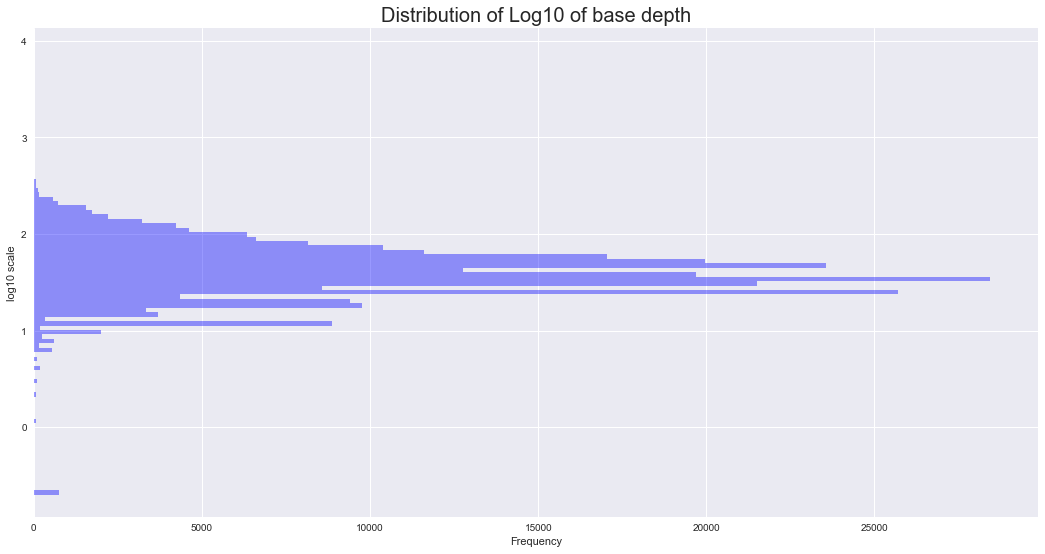

In [10]:
def sideways_hist(ser, title):
    """plots histogram sideways to reflect physical nature of data"""
    plt.figure(figsize=(18, 9))
    g = sns.distplot(np.log10(ser + .1), 
                     vertical=True, kde=False, bins=100, color='b')
    g.set_title(title, size=20)
    g.set_xlabel("Frequency")
    g.set_ylabel("log10 scale")
    plt.show();
sideways_hist(all_data_full_df.base.fillna(.1), 
              "Distribution of Log10 of base depth")

The log transformed base depth looks relatively normal. I will windsorize data larger than 3 std dev. I will only change the right (higher on the above chart) tail.

In [11]:
log10_base = np.log10(all_data_full_df.base + .1)
log_mean = log10_base.mean()
log_std = log10_base.std()
log_base_cutoff = log_mean + 3*log_std
base_cutoff = 10**log_base_cutoff

In [12]:
print(f"The cutoff is {round(log_base_cutoff, 3)} on the log chart above, or {round(base_cutoff, 3)} inches of snow.")

The cutoff is 2.412 on the log chart above, or 258.5 inches of snow.


In [13]:
def outlier_remover(df, col, limit):
    """ fixes outlier values
    replaces values in col (base or snowfall) with prior values
    NaNs in backup col"""
    df["old_col"] = df[col]
    if col == "base":
        # backup NaNs
        df['nan_locs'] = np.where(df[col].isna(), True, False)
        # fill overlimits with backvalues
        df[col] = np.where((df[col]>limit), np.NaN, df[col])
        df[col] = df[col].fillna(method='ffill', axis=0)
        # return NaNs to column
        df.loc[df.nan_locs, col] = np.NaN
        df = df.drop(columns=['nan_locs'])
    elif col == "snowfall":
        df[col] = np.where(df[col]>limit, 0, df[col])
    df = df.drop(columns=['old_col'])
    return df

In [14]:
all_data_full_df = all_data_full_df.pipe(outlier_remover, col='base', 
                                         limit=base_cutoff)

In [15]:
def region_concater(df):
    """Create 'pseudo_ts': a timestamp sorting all stations in a region into a 
    single consecutive timeseries. assign ranks to stations w/in each region; 
    sort stations by ranks, and offset timestamp years by the ranks
        """
    yrs_of_data = 9
    def station_ranker(gbdf):
        """takes groupby df and groups by station and returns with columns"""
        stations = gbdf.station.unique()
        def ski_yr_counter(station_df):
            station_df = df.rename_axis(None) 
            return station_df[['ski_yr']].nunique()
        ski_yrs = gbdf.groupby('station').apply(ski_yr_counter)
        assert (ski_yrs == yrs_of_data).all().all()
        station_rank = {station: rank for rank, station in enumerate(stations)}
        return station_rank

    ranks = (df.groupby(['region'])[['station', 'region']]
             .apply(station_ranker)
             .to_frame().rename(columns={0: 'data'})
             )

    offsets_df = pd.concat([pd.DataFrame
                            .from_dict(ranks[ranks.index == index].values[0][0],
                                       orient='index')
                            .rename(columns={0: 'offset'})
                            for index in ranks.index], axis=0)
    dayspyr = 365
    def vec_dt_replace(series, year=None, month=None, day=None):
        return pd.to_datetime(
        {'year': series.dt.year if year is None else year,
         'month': series.dt.month if month is None else month,
         'day': series.dt.day if day is None else day})
    df = (df
          .sort_values(by=['state', 'station', 'timestamp'], ascending=True)
          .assign(offset=lambda x: x.merge(right=offsets_df,
                                           left_on='station',
                                           right_index=True, )
                                   ['offset'],
                  pseudo_ts_delt=lambda x: (x.offset * yrs_of_data).round(0).astype(int, errors='ignore'),
                  new_year=lambda x: x.timestamp.dt.year - x.pseudo_ts_delt,)
          .query('new_year>1691')
          .assign(pseudo_ts=lambda x: vec_dt_replace(x.timestamp, year=x.new_year),
                  pseudo_ski_yr=lambda x: x.ski_yr - x.offset
                  )
          .drop(columns=['offset', 'new_year'])
          .dropna(how='any', inplace=False, thresh=2)
          )
    return df

In [16]:
long_series_df = region_concater(all_data_full_df)
long_series_df.head()

,dayofyr,timestamp,base,station,snowfall,ski_yr,state,region,pseudo_ts_delt,pseudo_ts,pseudo_ski_yr
13735,82,2010-11-16,72.0,Alyeska,NaN,0,alaska,Other,54.0,1956-11-16,-6.0
13736,85,2010-11-19,65.0,Alyeska,NaN,0,alaska,Other,54.0,1956-11-19,-6.0
13737,86,2010-11-20,64.0,Alyeska,NaN,0,alaska,Other,54.0,1956-11-20,-6.0
13738,87,2010-11-21,63.0,Alyeska,NaN,0,alaska,Other,54.0,1956-11-21,-6.0
13739,88,2010-11-22,62.0,Alyeska,NaN,0,alaska,Other,54.0,1956-11-22,-6.0


In [17]:
def base_plotter(name=None, what=None, df=long_series_df):
    """name is name of station OR region; 
    'what' takes 'station' or 'region'"""
    station_data = df[df[what] == name]
    base_chart = (alt.Chart(station_data)
                  .mark_line().encode(x='dayofyr:Q',
                                      y=alt.Y('base:Q', 
                                              aggregate='mean',
                                             ),
                                      color='pseudo_ski_yr:T',
                                      tooltip=['base_mean:Q']
                                      )
                  .properties(title=alt.TitleParams(
                        text=[f'Snow Base Average at {name}'],
                        subtitle=['starts from begining of ski season']  ))
                  )
    band = (alt.Chart(station_data)
            .mark_errorband(extent='ci')
            .encode(x='dayofyr:Q', 
                    y='base:Q',)
           )

    combined_chart = base_chart + band

    combined_chart.display()
    return combined_chart
_ = base_plotter('Arapahoe Basin', 'station')

alt.LayerChart(...)

### Closing Date
We will attempt to locate and compare closing dates.

In [18]:
def closing_dt_finder(df):
    """finds last date of season by looking for records where prior record is more
    than 60 days prior"""
    df = df.sort_values(by=['region', 'station', 'pseudo_ts'])
    df['difference'] = df.pseudo_ts.diff()
    summer = timedelta(days=60)
    df['season_start'] = np.where((df.difference > summer), True, False)
    df['season_start'] = np.where((df.station != df.station.shift()), 
                                  True, df.season_start)
    df['season_end'] = np.where((df.difference > summer).shift(-1), True, False)
    df['season_end'] = np.where((df.station != df.station.shift(-1)), 
                                True, df.season_end)
    df = df.drop(columns=['difference'])
    return df

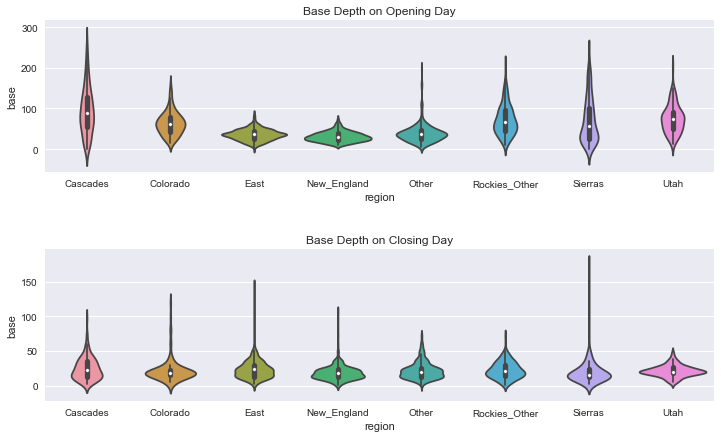

In [19]:
season_starts_df = long_series_df.pipe(closing_dt_finder).query('season_start==True')
season_ends_df = long_series_df.pipe(closing_dt_finder).query('season_end==True')
fig, ax = plt.subplots(2, figsize=(12, 7))
sns.violinplot(data=season_ends_df, x='region', y='base', ax=ax[0])
ax[0].set_title("Base Depth on Opening Day")
sns.violinplot(data=season_starts_df, x='region', y='base', ax=ax[1])
ax[1].set_title("Base Depth on Closing Day")
fig.subplots_adjust(hspace=.5);

In [20]:
def sorted_boxplot(data, x, y, title):
    '''avoid duplicating code for sorted boxplots on this dataset'''
    plt.rc('figure', figsize=(12.0, 7.0))
    order = data.groupby([y]).mean().sort_values(by=x).index
    plot = sns.boxplot(data=data, x=x,
                       y=y, order=order)
    plt.title(title, size=18)
    return plot

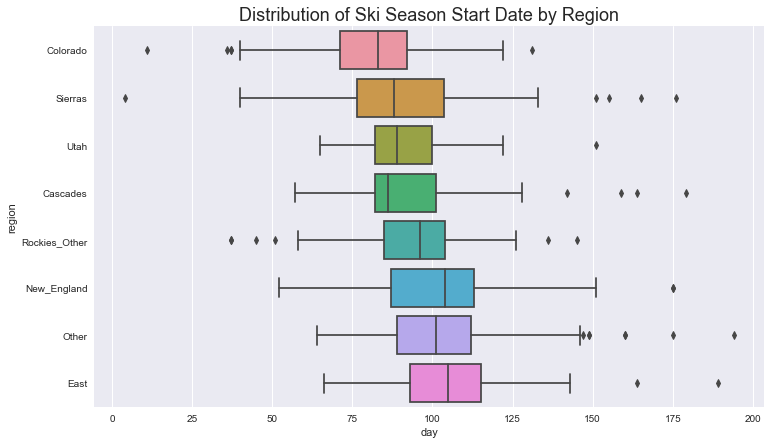

In [21]:
season_starts_df = season_starts_df.assign(day=lambda x: 
                                           (x.timestamp.dt.dayofyear + 125)%365)
sorted_boxplot(data=season_starts_df, x='day', y='region', 
               title="Distribution of Ski Season Start Date by Region");

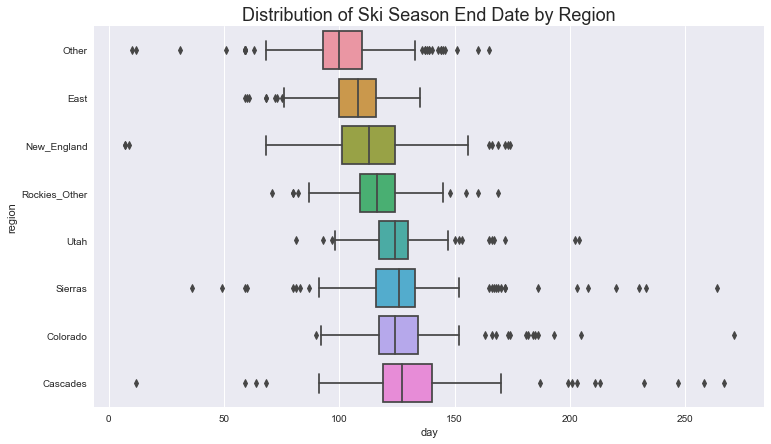

In [22]:
season_ends_df = season_ends_df.assign(day=lambda x: (x.timestamp.dt.dayofyear+20)%365)
sorted_boxplot(data=season_ends_df, x='day', y='region', 
            title="Distribution of Ski Season End Date by Region");

In [23]:
season_length = (pd.merge(left=season_starts_df, right=season_ends_df, 
                         on=['station', 'ski_yr'], suffixes=('_start', '_end'))
                 .assign(length=lambda x: (x.timestamp_end-x.timestamp_start).dt.days)
                 .rename(columns={'region_start': 'region'})
                 [['station', 'region', 'length', 'timestamp_start', 'timestamp_end']]
                 .query('length>70')  # there are some negative values due to missing values
                )

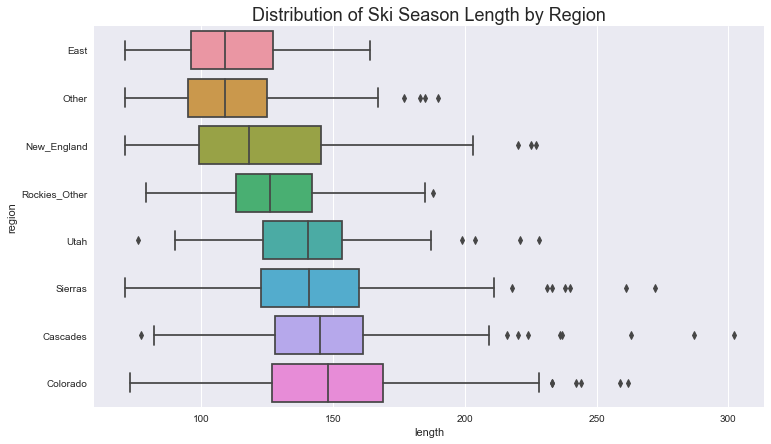

In [24]:
sorted_boxplot(data=season_length, x='length', y='region', 
               title="Distribution of Ski Season Length by Region");

In [25]:
season_length.to_parquet(season_length_path)

## Filling in Nans
There a large seasonal gap during the extended summer months when no data is recorded. Simple interpolation will not account for the warmer weather, and modeled approaches will actually be extrapolation since the data for this time period is outside what is ever seen by the models. I will fill in the missing data.

In [26]:
def make_complete_for_region(df):
    """fill NaNs; add rows for days not in time series and interpolate values"""
    zero_months = np.array([8])  # 8==August

    # col types
    unchanging = ['station', 'ski_yr', 'state', 'pseudo_ski_yr', 'region']
    increment = ['dayofyr', ]
    zero_out = ['snowfall']
    bools = ['basecol_interpolated']

    # reindex with missing index values
    desired_index_df = pd.DataFrame({'new_dates':
                                     pd.date_range(start=df.pseudo_ts.min(),
                                                   end=df.pseudo_ts.max(),
                                                   freq='d')})
    df = (df
          .merge(right=desired_index_df, left_on=["pseudo_ts"],
                 right_on=["new_dates"],
                 how='right')
          .drop(columns='pseudo_ts')
          .rename(columns={'new_dates': 'pseudo_ts'})
          .sort_values(by=['pseudo_ts'])
          )

    df[unchanging] = df[unchanging].ffill(axis=0).bfill(axis=0)

    for col in increment:
        # fill blanks using +1 incrementing over contiguous nulls
        df[col] = df[col].ffill() + df.groupby(df[col].notnull().cumsum()).cumcount()

    # notate rows with interpolated base data; fill in august with zero
    df = (df.assign(basecol_interpolated=lambda x: np.where(
                x.base.isna(), True, False))
          .assign(base=np.where(
                np.isin(df.pseudo_ts.dt.month, zero_months), 0, df['base']))
         )

    # interp only works if values on both sides
    def start_end_filler(ser, position):
        """fills NAN at start or end of series
        np.NaN doesn't equal itself"""
        ser1 = ser.copy()
        if ser1.iloc[position] != ser1.iloc[position]:
            ser1.iloc[position]=0
        return ser1
    df['base']=start_end_filler(df.base, position=0)
    df['base']=start_end_filler(df.base, position=-1)

    def interpolater(df):
        """applies interpolator function without losing index values.
        some interpolators need monotonically increasing index not DT"""
        index_= df.index
        df = (df.reset_index(drop=True)
              .assign(base=lambda x: np.where(
                  x.basecol_interpolated == True,
                  x.base.interpolate(method='polynomial',
                                     order=3, limit_direction="both"),
                  x.base))
              .set_index(index_, drop=True)
              )
        # no negatives from the interpolation
        df = np.where(df.base < 0, 0, df.base)
        return df

    df['base'] = df.pipe(interpolater)

    df[zero_out] = df[zero_out].fillna(value=0)
    return df


def apply_make_complete_to_regions(df):
    """runs nan filling function on all regions and concats"""
    return pd.concat([df.query('region==@region').pipe(make_complete_for_region)
                      for region in df.region.unique()])

In [27]:
long_interpolated_df = long_series_df.pipe(apply_make_complete_to_regions)

### View results of interpolation

In [28]:
def subsetter(df=None, region="Utah", tf=(2011, 2019)):
    '''create subset and notate start and stop of interpolated regime
    Utah is just a default'''

    return (df
            .query('region==@region')
            .query('pseudo_ts.dt.year>@tf[0] & pseudo_ts.dt.year<@tf[1]')
            )

subset = subsetter(long_interpolated_df)

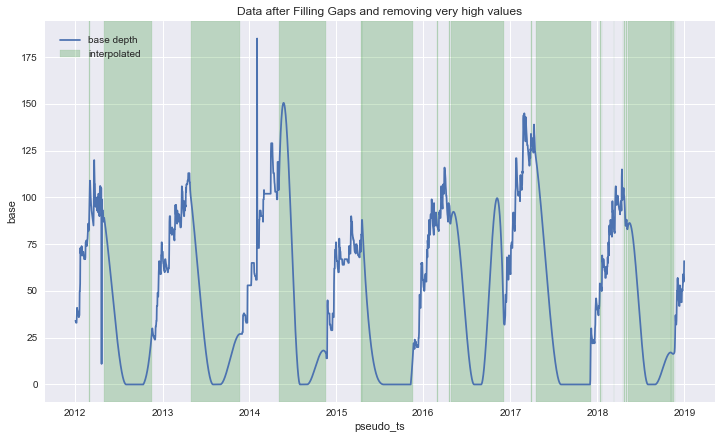

In [29]:
def get_interpolated_spans(subset):
    """specifies interpolated periods for plotting purposes"""
    stop_starts = (subset[['basecol_interpolated', 'pseudo_ts']]
                   .assign(interp_start=lambda x: np.where(
                       x.basecol_interpolated > x.basecol_interpolated.shift(1, fill_value=0),
                       True, False))
                   .assign(interp_stop=lambda x: np.where(
                       x.basecol_interpolated < x.basecol_interpolated.shift(1, fill_value=0),
                       True, False))
                   .query('(interp_start==True) | (interp_stop==True)')
                   )
    interp_periods = (stop_starts
                      .assign(interp_end_dt=lambda x: x.pseudo_ts.shift(-1))
                      .replace({pd.NaT: stop_starts.pseudo_ts.max()})
                      .query('interp_start==True')
                      .drop(columns=['interp_stop', 'basecol_interpolated',
                                     'interp_start'])
                      .rename(columns={'pseudo_ts': 'interp_start_dt'})
                      )
    return interp_periods

def line_with_marker(df, Title):
    ax = sns.lineplot(data=df, x='pseudo_ts', y='base',
                 markers=False, legend='full', label="base depth")
    plt.title(Title)
    periods = get_interpolated_spans(subset)
    for i, row in enumerate(periods.itertuples()):
        plt.axvspan(row[1], row[2], alpha=.2, color='green', 
                    label =  "_"*i + "interpolated")
    ax.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1,)
    plt.show()
line_with_marker(subset, "Data after Filling Gaps and removing very high values")

There are some values still that jump drastically from the values around them and are probably either measurement noise or bad values. I would like to remove some of the extreme values. This needs to occur now, after interpolating values, so jumps due to end-of-season effects don't get picked up by the function.

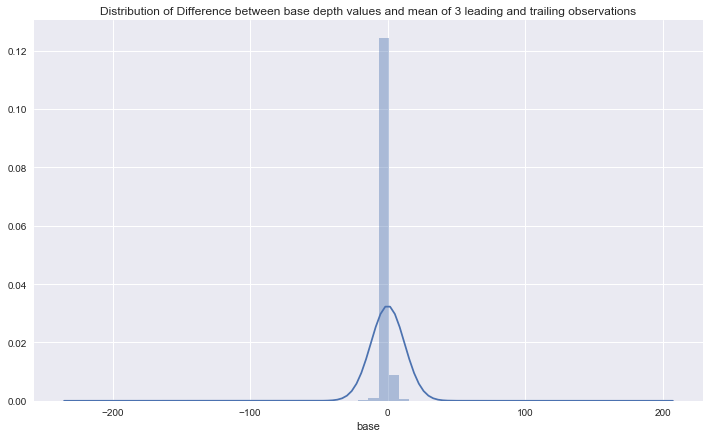

In [30]:
# calculate value vs neighbors
def get_excl_rolling_change(ser):
    """get series that is difference of value in each row and mean of 3 
    prior and following values. 
    """
    rolling_av_exc = (ser
                      .fillna(0)
                      .rolling(window=[1,1,1,0,1,1,1], center=True, 
                               win_type='boxcar')
                      .mean().fillna(0)  # fill blanks from offset issues
                     )
    return rolling_av_exc, rolling_av_exc - ser.fillna(0)

diff_vs_rolling_av = get_excl_rolling_change(long_interpolated_df.base)[1]
sns.distplot(diff_vs_rolling_av, kde_kws={'bw': 12})
plt.title("Distribution of Difference between base depth values and mean of 3 leading and trailing observations")
plt.show();

In [31]:
#test normality. Shapiro test works best at n<=5,000
shap_p = shapiro(sample(diff_vs_rolling_av.to_numpy().tolist(), k=5_000))[1]
print(f"shapiro p-value is {shap_p}")

shapiro p-value is 0.0


In [32]:
stats.normaltest(diff_vs_rolling_av)

NormaltestResult(statistic=718276.3215989966, pvalue=0.0)

We have to accept null hypothesis that distribution isn't gaussian. I will still use std cutoffs though running through a transform would be marginally better.

I will also use a qq plot to evaluate the distribution.

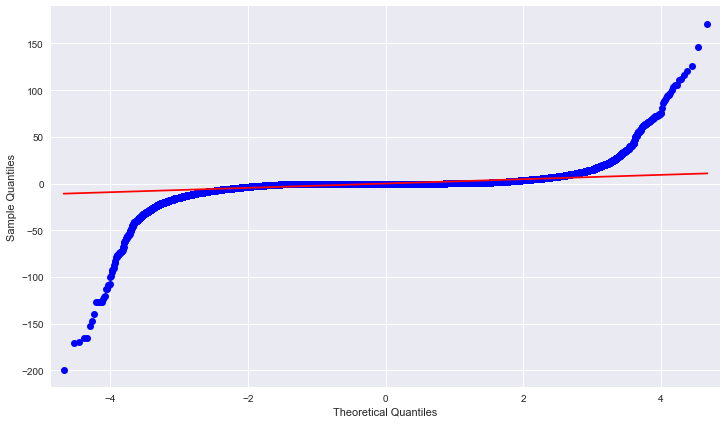

In [33]:
# q-q plot
qqplot(diff_vs_rolling_av, line='s')
plt.show()

In [34]:
stats.kurtosis(diff_vs_rolling_av, fisher=False)

789.8659419932403

The values are strongly leptokurtic. 

There is a strong break around 3.5 standard deviation on the left side. The right side has less of a clear break but around 4 standard deviations there is a break. I will windsorize on 4 standard deviations. Ideally I could investigate the outliers a bit more to determine the best cut point. 

In [35]:
def rolling_windsorize(ser, std_at_cut):
    """
    windsorizes series ser with a cutoff at the number of standard deviation in
    std_at_cut.
    e.g. std_at_cut==2 windsorizes values beyond -2 & 2 standard devaations
    for windsorized values, actual value is replaced with value +- the maximum
    change value as defined by std dev cutoff.
    """
    avg_ser, diff_ser = get_excl_rolling_change(ser.copy())
    std_limits = np.array([-diff_ser.std(), diff_ser.std()]) + diff_ser.mean()
    ser = np.where(diff_ser<std_limits[0], avg_ser + std_limits[0], ser)
    ser = np.where(diff_ser>std_limits[1], avg_ser + std_limits[1], ser)
    return ser

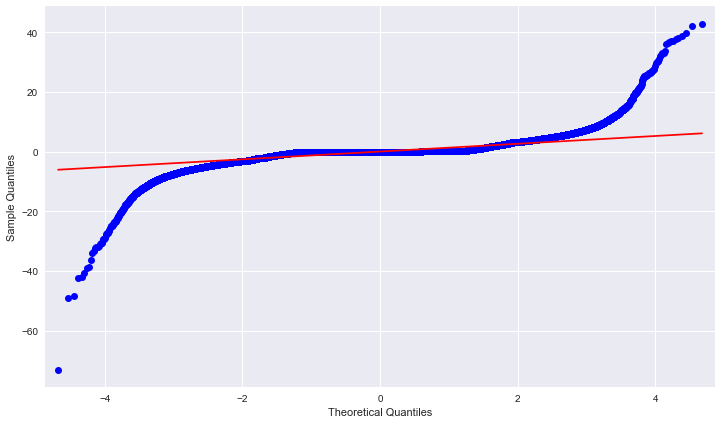

In [36]:
snow_clean_df = (long_interpolated_df
                 .assign(base=lambda x: rolling_windsorize(x.base, 4))
                )
qqplot(get_excl_rolling_change(snow_clean_df.base)[1], line='s')
plt.show()

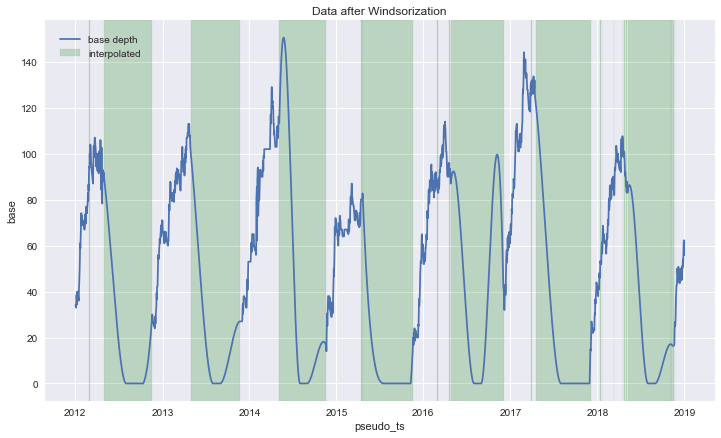

In [37]:
new_subset = subsetter(snow_clean_df)
line_with_marker(new_subset, "Data after Windsorization")

#### pickle output

In [38]:
snow_clean_df.to_parquet(fname=data_output_path)

# Snowfall EDA
viz when snow falls, by region

In [39]:
# snowfall distribution for each region
long_by_month_df = (snow_clean_df
                    .fillna(0)
                    .assign(month=lambda x: np.mod((x.pseudo_ts.dt.month+5), 12))
                    .set_index('pseudo_ts')
                    .groupby(['month', 'region'])
                    .agg(snowfall=('snowfall', np.mean),)
                    .reset_index()
                    )

snow_plot = (alt.Chart(long_by_month_df)
             .mark_line()
             .encode(
                 x=alt.X('month:Q', title="Month in Ski Year", axis=alt.Axis(
                     labels=True, ticks=True),
                         scale=alt.Scale(domain=[0, 12])),
                 y='snowfall:Q',
                 color=alt.Color('region', scale=alt.Scale(scheme='dark2')),
                 tooltip=['region:N', 'month:Q', 'snowfall:Q']
                     )
             .properties(title=alt.TitleParams(
                         text=[f'Average Daily Snowfall in Each Month'],
                         subtitle=['By Region']),
                         width=600,
                         height=400
                        )
            )
snow_plot.display()

alt.Chart(...)